In [12]:
import igl
import scipy
import numpy as np
from meshplot import plot, subplot, interact
import os
from scipy.sparse import csr_matrix
from pygsp.graphs import Graph
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

root_folder = os.path.join(os.getcwd(), "ghcn_data")
root_folder

'/Users/Mart/Documents/EPFL/transphere/martino/ghcn_data'

In [2]:
class cotan(Graph):

    def __init__(self, coords):
        self.coords = coords
        self.tri = ConvexHull(self.coords).simplices
        self.npix = np.alen(self.coords)
        W = csr_matrix((self.npix, self.npix), dtype=np.float32)
        self.cotan = igl.cotmatrix(self.coords, self.tri)
        self.mass = igl.massmatrix(self.coords, self.tri, igl.MASSMATRIX_TYPE_BARYCENTRIC)
        W = scipy.sparse.diags(1/self.mass.diagonal()) @ self.cotan
        W.setdiag(0, 0)
        super(cotan, self).__init__(W, coords=self.coords)
    
    def e(self, k=5):  # how many eigenvectors do I calculate
        self.eig_values, self.eig_vectors = scipy.sparse.linalg.eigsh(-self.cotan, k=k, M=self.mass, sigma=0.001)
    
    def plot_e(self, N=1):
        plot(self.coords, self.tri, self.eig_vectors[:,N])
    

# 1) GHCN

In [52]:
def create_GHCN(nstations = 500):
    stations = np.load('ghcn_data/ghcn_stations_2010-2014.npz')
    data = np.load('ghcn_data/ghcn_data_2010-2014_TMAX.npz')
    
    keep = data['valid_days'].flatten()
    data = data['data'].reshape(len(stations['id_ghcn']), -1)
    data = data[:, keep]
    data = data / 10

    # Show the same stations as for the temperature plot.
    year, month, day = 2014, 1, 1
    t = (year-2010)*365 + (month-1)*30 + (day-1)
    keep = ~np.isnan(data[:, t])

    data = data[keep]
    lon = stations['lon'][keep]
    lat = stations['lat'][keep]

    print('n_stations: {}, n_days: {}'.format(nstations, data.shape[1]))

    # Rotate the view.
    lon -= 50
    lat -= 20

    lon *= np.pi / 180
    lat *= np.pi / 180

    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)

    coords = np.stack([x, y, z], axis=1)
    max_stations = np.alen(coords)
    if nstations > max_stations:
        print("warning: there are only {} stations".format(np.alen(coords)))
        return coords
    return coords[np.random.permutation(np.alen(coords))][:nstations]

In [53]:
coords = create_GHCN(nstations = 1000)

n_stations: 1000, n_days: 1826


In [54]:
sphere = cotan(coords)

In [57]:
sphere.e(k=50)

In [63]:
sphere.plot_e(5)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0215089…

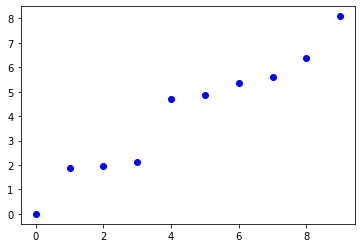

In [61]:
plt.plot(sphere.eig_values[:10], 'bo')

# 2) Cotan VS B&N

## 2.1) Equiangular

### 2.1.1) cotan

In [4]:
def create_equiangular(bw):
    alpha = np.arange(2 * bw) * np.pi / bw
    beta = np.arange(2 * bw) * np.pi / (2. * bw)
    theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
    ct = np.cos(theta).flatten()
    st = np.sin(theta).flatten()
    cp = np.cos(phi).flatten()
    sp = np.sin(phi).flatten()
    x = st * cp
    y = st * sp
    z = ct
    coords = np.vstack([x, y, z]).T
    coords = np.asarray(coords, dtype=np.float32)
    coords = coords[2*bw-1:]
    return coords

In [5]:
bw = 128
coords = create_equiangular(bw)

In [6]:
k = 50
sphere = cotan(coords)
sphere.e(k)

2019-12-09 12:15:17,153:[WARNING](pygsp.graphs.graph.__init__): Adjacency: there are negative edge weights.


In [7]:
sphere.plot_e(49)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

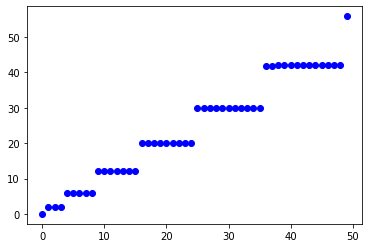

In [33]:
plt.plot(sphere.eig_values, 'bo')

### 2.1.2) B&N

In [44]:
from scipy import spatial
from scipy import sparse

class SphereEquiangular(Graph):
    """class taken from Frederick Gusset's repo
    https://github.com/Droxef/PDMdeepsphere/blob/master/Experiments/Graphs/equiangular_and_other_graphs.ipynb"""
    
    def __init__(self, bw=64, sptype='DH', pole='disconnected', neighbors=8, w_mat=None, dist='geodesic', 
                 affine=0., geometry='sphere', delta='one', **kwargs):
        """Sphere with an equiangular sampling
         Parameters
        ----------
        bw : int
            bandwidth, size of grid  (default = 64)
        sptype: str
            sampling type, possible arguments are 'DH', 'SOFT', ... (default = 'DH')
        pole: str
            how to manage the pole of the cylinder, possible arguments are 'disconnected', 'connected' (default = 'disconnected')
        ---------
        TODO: unique on neighbor
        TODO: CC and GL are not equiangular and must be implement in other ways
        """
        self.bw = bw
        self.sptype = sptype
        self.pole = pole
        if pole not in ['disconnected', 'connected']:
            raise ValueError('Unknown pole value:' + pole) 
        if sptype not in ['DH', 'SOFT', 'CC', 'GL']:
            raise ValueError('Unknown sampling type:' + sptype) 
        if neighbors not in [4, 8, 'all', 'full']:
            raise ValueError('impossible numbers of neighbors:' + neighbors) 
        
        ## sampling and coordinates calculation
        if sptype is 'DH':
            beta = np.arange(2 * bw) * np.pi / (2. * bw)  # Driscoll-Heally
            alpha = np.arange(2 * bw) * np.pi / bw
        elif sptype is 'SOFT':  # SO(3) Fourier Transform optimal
            beta = np.pi * (2 * np.arange(2 * bw) + 1) / (4. * bw)
            alpha = np.arange(2 * bw) * np.pi / bw
        elif sptype == 'CC':  # Clenshaw-Curtis
            beta = np.linspace(0, np.pi, 2 * bw + 1)
            alpha = np.linspace(0, 2 * np.pi, 2 * bw + 2, endpoint=False)
        elif sptype == 'GL':  # Gauss-legendre
            from numpy.polynomial.legendre import leggauss
            x, _ = leggauss(bw + 1)  # TODO: leggauss docs state that this may not be only stable for orders > 100
            beta = np.arccos(x)
            alpha = np.arange(2 * bw + 2) * np.pi / (bw + 1)
        theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
        self.lat, self.lon = theta.shape
        # do we want cylinder coordinates?
        if geometry == 'sphere':
            ct = np.cos(theta).flatten()
            st = np.sin(theta).flatten()
        elif geometry == 'cylinder':
            ct = theta.flatten() * 2 * bw / np.pi
            st = 1
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        coords = np.asarray(coords, dtype=np.float32)
        self.npix = len(coords)
        
        if neighbors=='full':
            self.coords = coords
            distances = spatial.distance.cdist(coords, coords)**2
            weights = 1 / distances
            for i in range(np.alen(weights)):
                weights[i, i] = 0.
            W = sparse.csr_matrix(weights, dtype=np.float32)
            plotting = {"limits": np.array([-1, 1, -1, 1, -1, 1])}
            super(CylinderEquiangular, self).__init__(W=W, coords=coords,
                                     plotting=plotting, **kwargs)
            return
        
        ## neighbors and weight matrix calculation
        def one(x):
            return 1
        if delta == 'one':
            fun = one
        else:
            def fun(x):
                lat = abs(x//self.lat - self.lat//2)
                delta = 1+lat*(self.lon-1)/self.lat
                return int(delta)
        
        def south(x):
            if x >= self.npix - self.lat:
                if pole == 'connected':
                    return (x + self.lat//2)%self.lat + self.npix - self.lat
                else:
                    return -1
            return x + self.lon

        def north(x):
            if x < self.lat:
                if pole == 'connected':
                    return (x + self.lat//2)%self.lat
                else:
                    return -1
            return x - self.lon

        def west(x, fun=fun):
            delta = fun(x)
            if x%(self.lon)<delta:
                try:
                    assert x//self.lat == (x-delta+self.lon)//self.lat
                except:
                    print(x)
                    print(delta)
                    print(x-delta+self.lon)
                    print(x//self.lat)
                    print((x-delta+self.lon)//self.lat)
                    raise
                x += self.lon
            else:
                try:
                    assert x//self.lat == (x-delta)//self.lat
                except:
                    print(x)
                    print(delta)
                    print(x-delta)
                    print(x//self.lat)
                    print((x-delta)//self.lat)
                    raise
            return x - delta

        def east(x, fun=fun):
            delta = fun(x)
            if x%(self.lon)>=self.lon-delta:
                try:
                    assert x//self.lat == (x+delta-self.lon)//self.lat
                except:
                    print(x)
                    print(delta)
                    print(x+delta-self.lon)
                    print(x//self.lat)
                    print((x+delta-self.lon)//self.lat)
                    raise
                x -= self.lon
            else:
                try:
                    assert x//self.lat == (x+delta)//self.lat
                except:
                    print(x)
                    print(delta)
                    print(x+delta)
                    print(x//self.lat)
                    print((x+delta)//self.lat)
                    raise
            return x + delta

        col_index=[]
        for ind in range(self.npix):
            # first line is the same point, so is connected to all points of second line
            if neighbors==8:
                neighbor = [south(west(ind)), west(ind), north(west(ind)), north(ind), 
                            north(east(ind)), east(ind), south(east(ind)), south(ind)]
            elif neighbors==4:
                neighbor = [west(ind), north(ind), east(ind), south(ind)]
            elif neighbors=='all':
                neighbor = set(range(self.npix))-{ind}
            else:
                neighbor = []
            #neighbor = np.asarray(neighbor)
            col_index += list(neighbor)
        col_index = np.asarray(col_index)
        if neighbors == 'all':
            neighbors = self.npix - 1
        row_index = np.repeat(np.arange(self.npix), neighbors)
        
        keep = (col_index < self.npix)
        keep &= (col_index >= 0)
        col_index = col_index[keep]
        row_index = row_index[keep]
        
        if w_mat is not 'one':
            
            if dist=='geodesic':
                distances = np.zeros(len(row_index))
                for i, (pos1, pos2) in enumerate(zip(coords[row_index], coords[col_index])):
                    d1, d2 = hp.rotator.vec2dir(pos1.T, lonlat=False).T, hp.rotator.vec2dir(pos2.T, lonlat=False).T
                    distances[i] = hp.rotator.angdist(d1, d2, lonlat=False)
            else:
                distances = np.sum((coords[row_index] - coords[col_index])**2, axis=1)

            def fun(x):
                
                val = np.abs(np.arange(x)-x//2)
                val = 0.3+val**1/200
                return val
            if delta != 'one':
                distances[::2] = distances[::2]*4#*fun(len(distances[1::2]))
            # Compute similarities / edge weights.
            kernel_width = np.mean(distances)
            kernel_width2 = np.median(distances)

            slope = (kernel_width2*(0.95-affine))/(kernel_width2*0.95)
            #distances[distances<(kernel_width2*0.95)] = affine*kernel_width2 + distances[distances<(kernel_width2*0.95)] * slope
            distances[distances>(kernel_width2*0.95)] = affine*kernel_width2 + distances[distances>(kernel_width2*0.95)] * slope
            if isinstance(w_mat, int):
                kernel_width = weights
            weights = np.exp(-distances / (2 * kernel_width2))
#             weights = 1/distances

            plt.hist(distances, 100)
        if w_mat == 'one':
            weights = np.ones((len(row_index),))
            near_pole = col_index<2
            near_pole &= col_index>self.lat-2
            weights[near_pole] *= 0.1

        # Similarity proposed by Renata & Pascal, ICCV 2017.
        # weights = 1 / distances

        # Build the sparse matrix.
        W = sparse.csr_matrix(
            (weights, (row_index, col_index)), shape=(self.npix, self.npix), dtype=np.float32)
        
        plotting = {"limits": np.array([-1, 1, -1, 1, -1, 1])}
        super(SphereEquiangular, self).__init__(adjacency=W, coords=coords,
                                     plotting=plotting, **kwargs)

<>:31: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:176: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:31: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:176: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-44-1cb6011dcd96>:31: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if sptype is 'DH':
<ipython-input-44-1cb6011dcd96>:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif sptype is 'SOFT':  # SO(3) Fourier Transform optimal
<ipython-input-44-1cb6011dcd96>:176: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if w_mat is not 'one':


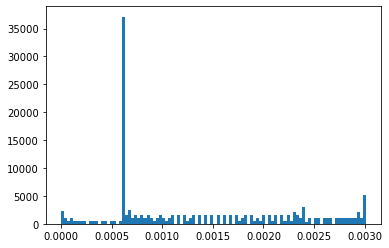

In [64]:
sphere = SphereEquiangular(bw=64, dist='euclidean', neighbors=8)

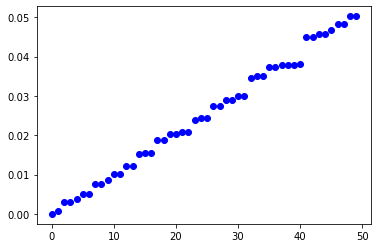

In [65]:
sphere.compute_fourier_basis(n_eigenvectors=50) 
plt.plot(sphere.e, 'bo')

## 2.2) HEALPix

### 2.2.1) cotan

In [18]:
import healpy as hp

def create_healpix(nside=32, nest=True):
    npix = hp.nside2npix(nside)
    indexes = np.arange(npix)
    x, y, z = hp.pix2vec(nside, indexes, nest=nest)
    coords = np.vstack([x, y, z]).transpose()
    return np.asarray(coords, dtype=np.float32)

In [19]:
coords = create_healpix()
k = 50
sphere = cotan(coords)
sphere.e(k)

2019-12-09 12:21:31,756:[WARNING](pygsp.graphs.graph.__init__): Adjacency: there are negative edge weights.


In [20]:
sphere.plot_e(49)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

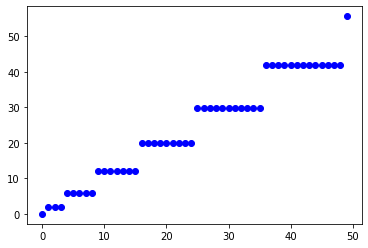

In [21]:
plt.plot(sphere.eig_values, 'bo')

### 2.2.2) B&N

In [22]:
from pygsp.graphs import SphereHealpix
sphere = SphereHealpix(nside=32, n_neighbors=8)

In [23]:
sphere.compute_fourier_basis(n_eigenvectors=50) 

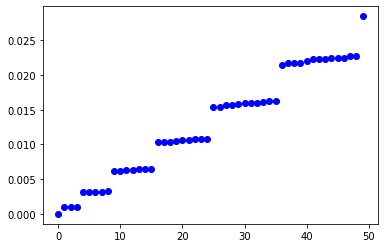

In [24]:
plt.plot(sphere.e, 'bo')